In [1]:
import os
import sys
import logging
import datetime
import json
import time
import numpy as np
from tqdm import tqdm

from transformers import TrainingArguments, Trainer

import torch
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from dataset_config import COCO_dataset_config
from custom_datasets.nice_dataset import NICETrainDataset, NICETestDataset
from utils import get_device_map

%matplotlib inline

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# devices = [0]
devices = [1, 5, 6, 7]
start_device = 'cuda:' + str(devices[0])

### Logging

In [3]:
# train result save dir name
results_dir = '../results'
result_dirname = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
result_dir_fullpath = os.path.join(results_dir, result_dirname)
os.makedirs(result_dir_fullpath, exist_ok=True)

In [4]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s: %(message)s",
    level=logging.INFO,
    datefmt="%I:%M:%S",
    handlers=[
        logging.FileHandler(os.path.join(result_dir_fullpath, 'train.log')),
        logging.StreamHandler(sys.stdout),
    ])

In [5]:
# tensorboard
writer = SummaryWriter(os.path.join('../runs', result_dirname))

### Configuration

In [6]:
# blip2 설정 참고하기
# https://github.com/salesforce/LAVIS/blob/main/lavis/projects/blip2/train/caption_coco_ft.yaml

checkpoint = "Salesforce/blip2-flan-t5-xl"
# cache_dir = "/mnt/nas2/kjh/huggingface_cache"
cache_dir = "../pretrained_files"
cfg_path = "../configs/caption_coco_ft.yaml"
dtype = torch.float32

batch_size=4
num_workers=4
max_length=50   # val에서 최대 토큰 개수가 44개

model_name = checkpoint.split("/")[1]

In [7]:
from omegaconf import OmegaConf, DictConfig

config = OmegaConf.load(cfg_path)

def dict_to_str_recursive(input_dict, depth=0):
    result_str = ''
    indent_str = '&nbsp;&nbsp;&nbsp;&nbsp;' * depth
    for key in input_dict:
        if type(input_dict[key]) in [dict, DictConfig]:
            value_str = dict_to_str_recursive(input_dict[key], depth + 1)
            result_str += indent_str + str(key) + ':  \n' + value_str + '  \n'
        else:
            value_str = str(input_dict[key])
            result_str += indent_str + str(key) + ': ' + value_str + '  \n'
    return result_str

config_str = dict_to_str_recursive(config)
writer.add_text('configs', config_str)

### Processor
##### image-processor + tokenizer

In [8]:
from transformers import Blip2Processor

processor = Blip2Processor.from_pretrained(
    checkpoint,
    cache_dir=cache_dir,
)

### Dataset

In [9]:
def custom_collate(batch):
    images = []
    captions = []
    attention_masks = []
    for sample in batch:
        images.append(sample[0])
        captions.append(torch.LongTensor(sample[1]))
        attention_masks.append(torch.Tensor(sample[2]))
    return torch.stack(images).contiguous(), torch.stack(captions).contiguous(), torch.stack(attention_masks).contiguous()

In [10]:
from dataset_config import nice_dataset_config
from torch.utils.data import DataLoader

train_ds = NICETrainDataset(
    img_dir=nice_dataset_config['val_image_folder'],
    ann_file=nice_dataset_config['val_caption_csv'],
    vis_processor=processor.image_processor,
    tokenizer=processor.tokenizer,
    max_length=max_length
)

train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
    collate_fn=custom_collate   # 이미지는 [batch_size, ...] 크기로 잘 가져오는데 text는 [max_token_length, batch_size] 이렇게 가져오는 문제가 있어서 custom_collate 구현
)

In [11]:
# prompt_tokens를 model의 input_ids로 넣고 있다.
prompt_tokens = processor.tokenizer(
    "a photo of", padding='max_length', max_length=max_length, return_tensors='pt'
)

### Plot Images

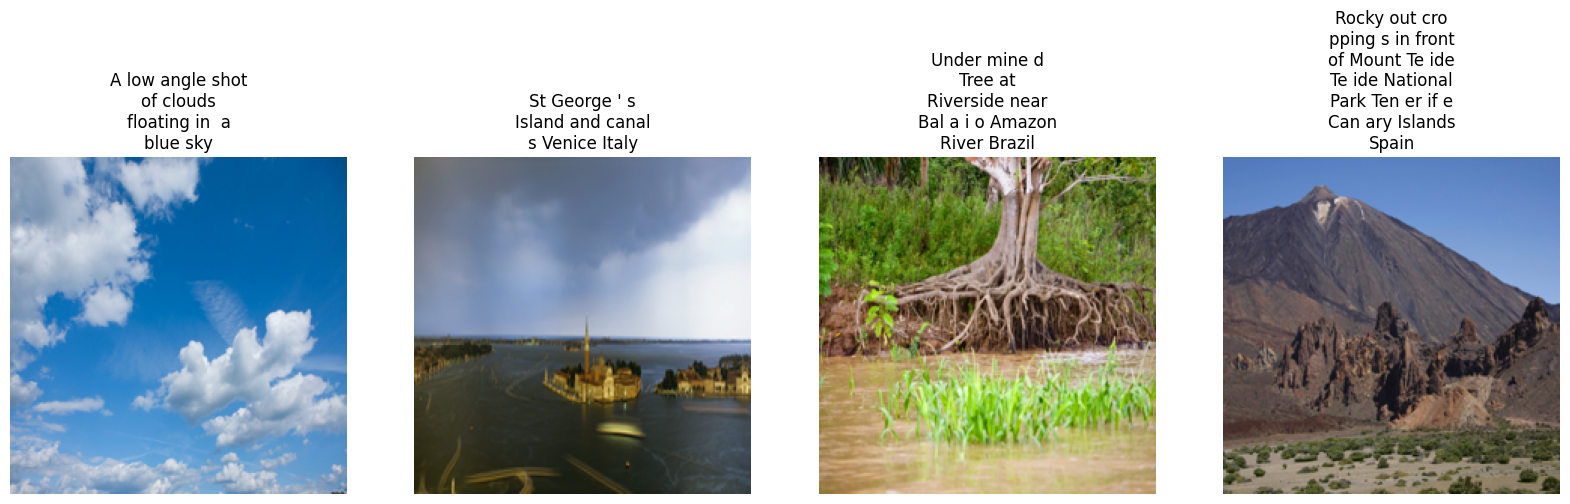

In [13]:
from utils import denormalize_image, plot_images

num_samples = min(5, batch_size)
pixel_values, input_ids, attention_masks = next(iter(train_dataloader))

sample_images = []
sample_captions = []
for i in range(num_samples):
    sample_image = np.array(pixel_values[i])
    sample_image = denormalize_image(sample_image, processor.image_processor.image_mean, processor.image_processor.image_std)
    sample_images.append(sample_image)
    
    sample_caption = ' '.join(processor.batch_decode(input_ids[i], skip_special_tokens=True))
    sample_captions.append(sample_caption)

plot_images(sample_images, sample_captions)

### Model

In [14]:
from transformers import Blip2ForConditionalGeneration

device_map = get_device_map(checkpoint, devices)

model = Blip2ForConditionalGeneration.from_pretrained(
    checkpoint,
    cache_dir=cache_dir,
    torch_dtype=dtype,
    device_map=device_map,
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:20<00:00, 10.41s/it]


In [15]:
#Freeze
block_list = [
    model.vision_model,
    model.qformer,
    model.language_projection,
    model.language_model,
]

freeze_list = [
    # model.vision_model,
    # model.qformer,
    # model.language_projection,
    model.language_model,
]

for freeze_block in freeze_list:
    for name, param in freeze_block.named_parameters():
        param.requires_grad = False
    freeze_block = freeze_block.eval()

# for block in block_list:
#     if block not in freeze_list:
#         for name, param in block.named_parameters():
#             param.requires_grad = True
#     block = block.train()

### Optimizer & Scheduler

In [16]:
num_parameters = 0
p_wd, p_non_wd = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue  # frozen weights
    if p.ndim < 2 or "bias" in n or "ln" in n or "bn" in n:
        p_non_wd.append(p)
    else:
        p_wd.append(p)
    num_parameters += p.data.nelement()

optim_params = [
    {
        "params": p_wd,
        "weight_decay": float(config.run.weight_decay),
    },
    {"params": p_non_wd, "weight_decay": 0},
]
beta2 = config.run.get("beta2", 0.999)
optimizer = torch.optim.AdamW(
    optim_params,
    lr=float(config.run.init_lr),
    weight_decay=float(config.run.weight_decay),
    betas=(0.9, beta2),
)

In [17]:
from scheduler import LinearWarmupCosineLRScheduler

lr_sched_cls = LinearWarmupCosineLRScheduler

max_epoch = config.run.max_epoch
min_lr = config.run.min_lr
init_lr = config.run.init_lr

# optional parameters
decay_rate = config.run.get("lr_decay_rate", None)
warmup_start_lr = config.run.get("warmup_lr", -1)
warmup_steps = config.run.get("warmup_steps", 0)

lr_scheduler = lr_sched_cls(
    optimizer=optimizer,
    max_epoch=max_epoch,
    min_lr=min_lr,
    init_lr=init_lr,
    decay_rate=decay_rate,
    warmup_start_lr=warmup_start_lr,
    warmup_steps=warmup_steps,
)

### Training

In [18]:
def train(train_dataloader):
    start_time = time.time()
    iters_per_epoch = len(train_dataloader)

    logging.info("Start training")
    for epoch in tqdm(range(0, max_epoch), desc='epochs', position=0):
        inner_epoch = epoch

        epoch_loss = 0.0
        for i, (pixel_values, input_ids, attention_masks) in enumerate(tqdm(train_dataloader, desc='iters', position=1)):
            pixel_values = pixel_values.to(start_device, dtype)

            lr_scheduler.step(cur_epoch=inner_epoch, cur_step=i)

            # model_output은 Blip2ForConditionalGenerationModelOutput 오브젝트
            # encoder-decoder 모델을 사용하는 경우 decoder_input_ids 변수에 값을 넣어줘야 함
            # input_ids와 decoder_input_ids는 어떻게 다른건지??
            # ->
            # https://huggingface.co/docs/transformers/main/model_doc/blip-2#transformers.Blip2ForConditionalGeneration
            # One can optionally pass input_ids to the model, which serve as a text prompt, to make the language model continue the
            # prompt. Otherwise, the language model starts generating text from the [BOS] (beginning-of-sequence) token.
            # 여기대로라면 "[BOS] + () + 생성된 토큰" 에서 ()에 들어갈 토큰
            
            # 논문 내용
            # For encoder-decoder-based LLMs, we pre-train with the prefix
            # language modeling loss, where we split a text into two parts.
            # The prefix text is concatenated with the visual representation
            # as input to the LLM’s encoder. The suffix text is used as the
            # generation target for the LLM’s decoder
            
            # 그럼 input_ids에 "a photo of " 토큰이 들어가야 하나?
            # decoder_input_ids는?

            # model_output = model(pixel_values, input_ids=prompt_tokens['input_ids'].repeat(batch_size, 1), attention_mask=attention_masks)
            model_output = model(pixel_values, input_ids=input_ids, decoder_input_ids=input_ids, attention_mask=attention_masks, return_dict=True)
            logits = model_output.loss.get('logits')
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = input_ids[..., 1:].contiguous().to(logits.device)
            
            print(torch.isnan(logits).any())
            print(torch.isnan(shift_labels).any())
            
            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(shift_logits.view(-1, 32128), shift_labels.view(-1))
            epoch_loss += loss.item()
            print(loss.item())

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
            # 빠르게 확인하기 위해 break
            break

        epoch_loss /= iters_per_epoch
        logging.info(f'{epoch} epoch loss: {epoch_loss:.6f}')
        writer.add_scalar('loss', epoch_loss, epoch)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    logging.info("Training time {}".format(total_time_str))


In [19]:
train(train_dataloader)

04:10:07 - INFO: Start training


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

tensor(False, device='cuda:1')
tensor(False, device='cuda:1')
42.22932434082031


iters:   0%|          | 0/1250 [00:05<?, ?it/s]

04:10:13 - INFO: 0 epoch loss: 0.033783



epochs:  20%|██        | 1/5 [00:05<00:23,  5.83s/it]

tensor(False, device='cuda:1')
tensor(False, device='cuda:1')
45.33771514892578


iters:   0%|          | 0/1250 [00:01<?, ?it/s]

04:10:15 - INFO: 1 epoch loss: 0.036270



epochs:  40%|████      | 2/5 [00:07<00:10,  3.55s/it]

tensor(False, device='cuda:1')
tensor(False, device='cuda:1')
41.7156867980957


iters:   0%|          | 0/1250 [00:01<?, ?it/s]

04:10:17 - INFO: 2 epoch loss: 0.033373



epochs:  60%|██████    | 3/5 [00:09<00:05,  2.83s/it]

tensor(False, device='cuda:1')
tensor(False, device='cuda:1')
40.36563491821289


iters:   0%|          | 0/1250 [00:01<?, ?it/s]

04:10:19 - INFO: 3 epoch loss: 0.032293



epochs:  80%|████████  | 4/5 [00:11<00:02,  2.47s/it]

tensor(False, device='cuda:1')
tensor(False, device='cuda:1')
44.75686264038086


iters:   0%|          | 0/1250 [00:01<?, ?it/s]

04:10:21 - INFO: 4 epoch loss: 0.035805



epochs: 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]

04:10:21 - INFO: Training time 0:00:13


--- Logging error ---
Traceback (most recent call last):
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/kjh/anaconda3/envs/my_env_NICE/lib/python3.9/site

a mountain bike is parked in the forest


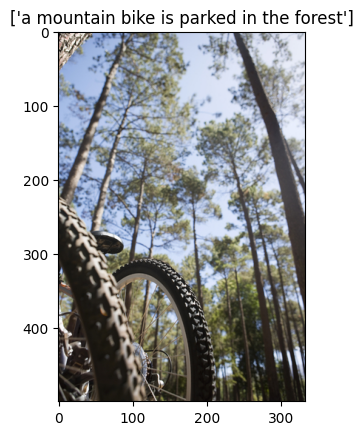

In [20]:
from PIL import Image
from utils import show_image_caption

image = '../datasets/cvpr-nice-val/val/215268662.jpg'
raw_image = Image.open(image).convert('RGB')

inputs = processor(raw_image, return_tensors="pt").to(start_device, dtype)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

show_image_caption(raw_image, [generated_text], show_fig=True)